# Разработка A/B-тестирования и анализ результатов

Команда разработчиков рекомендательных систем компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео, создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

**Задача** - рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

### Работа с историческими данными (EDA)

#### Загрузка исторических данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [5]:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [6]:
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберем любого из них.


In [8]:
# Рассчитываем количество уникальных сессий для каждого пользователя
unique_sessions_count = sessions_history.groupby('user_id')['session_id'].nunique()

In [9]:
# Находим пользователя с максимальным количеством уникальных сессий
max_sessions_user_id = unique_sessions_count.idxmax()
max_sessions_user_data = sessions_history[sessions_history['user_id'] == max_sessions_user_id]
display(max_sessions_user_data)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. 

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [11]:
#Рассчитываем число уникальных пользователей и число зарегистрированных пользователей для каждого дня
daily_registrations = sessions_history.groupby('session_date').agg(total_users=('user_id', 'nunique'),
                      registered_users=('registration_flag', lambda x: (x == 1).sum())).reset_index()
display(daily_registrations.head())

,session_date,total_users,registered_users
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840


In [12]:
# Доля зарегистрированных пользователей
daily_registrations['registration_rate'] = daily_registrations['registered_users'] / daily_registrations['total_users']
display(daily_registrations.head())

,session_date,total_users,registered_users,registration_rate
0,2025-08-11,3919,169,0.043123
1,2025-08-12,6056,336,0.055482
2,2025-08-13,8489,464,0.054659
3,2025-08-14,10321,625,0.060556
4,2025-08-15,14065,840,0.059723


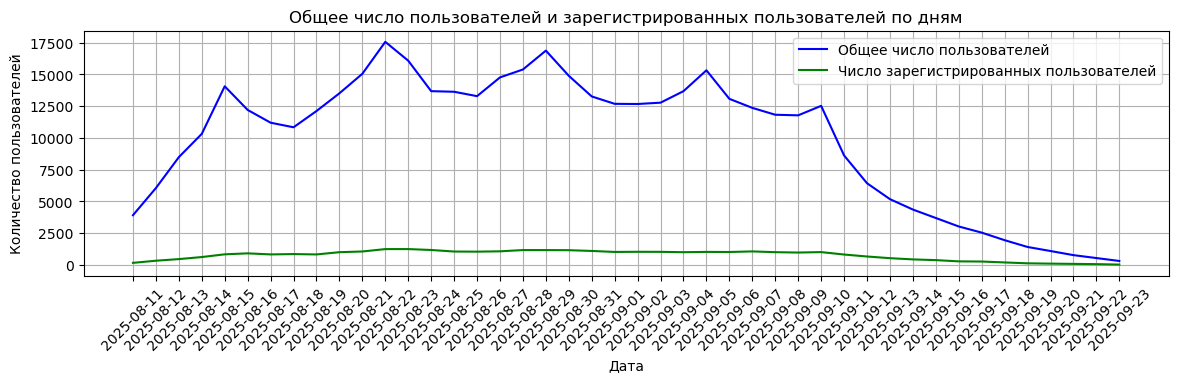

In [13]:
plt.figure(figsize=(14, 7))
# График общего числа пользователей и зарегистрированных пользователей
plt.subplot(2, 1, 1)
plt.plot(daily_registrations['session_date'], daily_registrations['total_users'], label='Общее число пользователей', color='blue')
plt.plot(daily_registrations['session_date'], daily_registrations['registered_users'], label='Число зарегистрированных пользователей', color='green')
plt.title('Общее число пользователей и зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

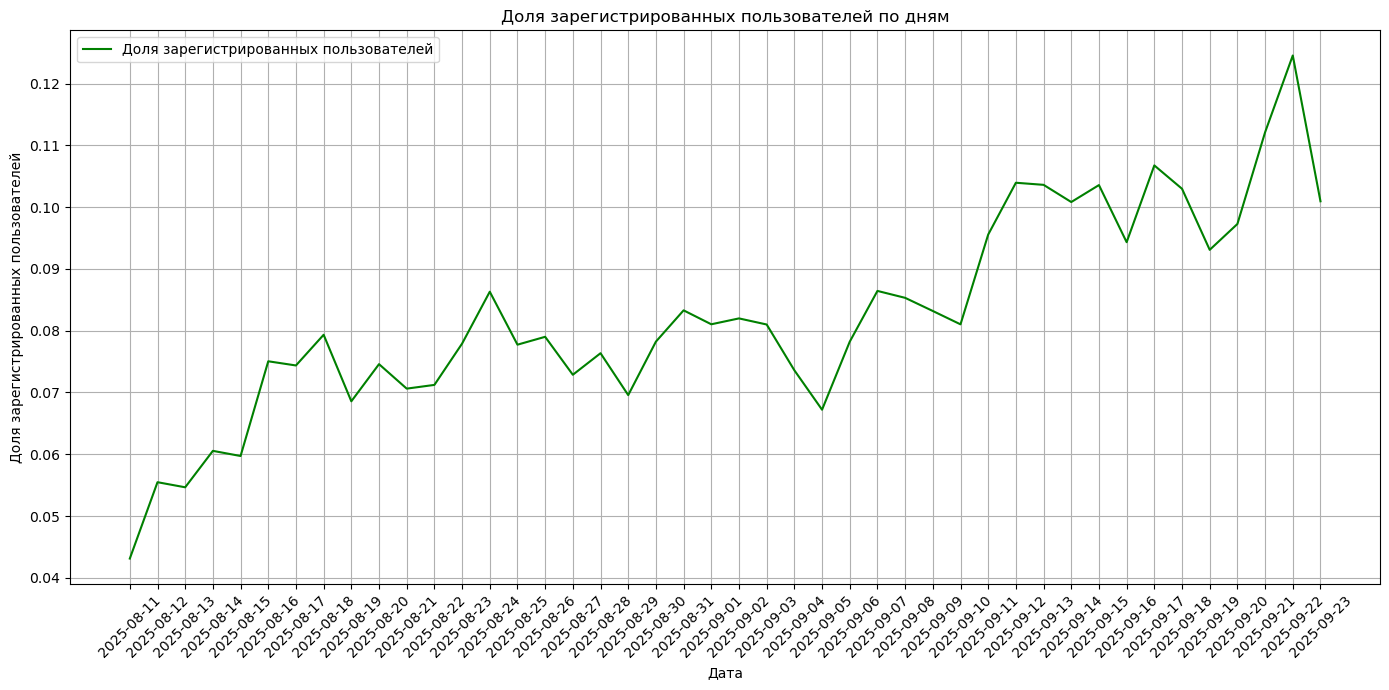

In [14]:
plt.figure(figsize=(14, 7))
# График доли зарегистрированных пользователей
plt.plot(daily_registrations['session_date'], daily_registrations['registration_rate'], label='Доля зарегистрированных пользователей', color='green')
plt.title('Доля зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

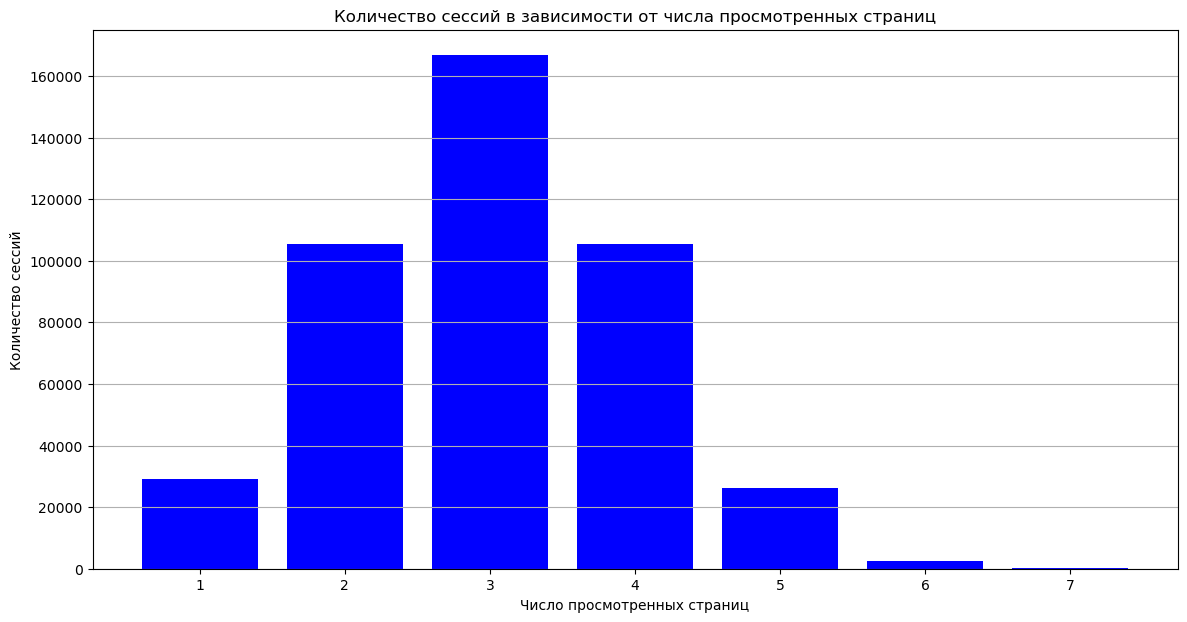

In [16]:
# Находим количество сессий для каждого значения количества просмотренных страниц
pages_count = sessions_history.groupby('page_counter')['session_id'].count().reset_index()
pages_count.columns = ['pages', 'session_count']

# Построение столбчатой диаграммы
plt.figure(figsize=(14, 7))
plt.bar(pages_count['pages'], pages_count['session_count'], color='blue')
plt.title('Количество сессий в зависимости от числа просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.xticks(pages_count['pages'])
plt.grid(axis='y')
plt.show()

#### Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

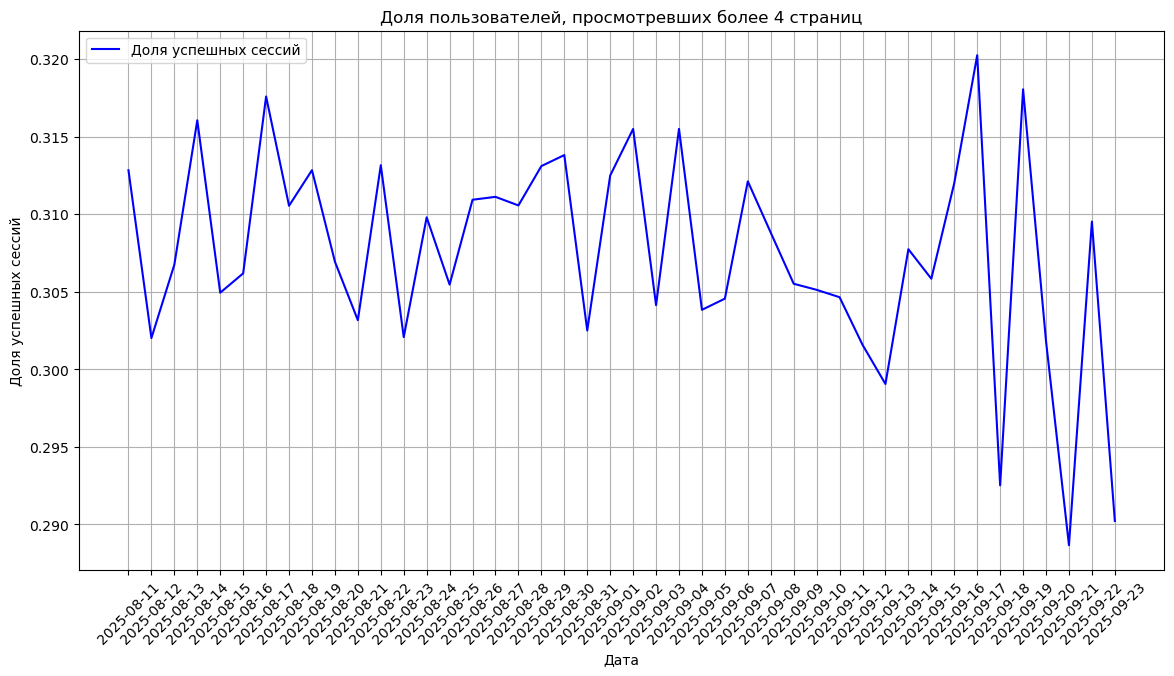

In [18]:
# Создаем новый столбец good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Агрегируем данные по дате
daily_good_sessions = sessions_history.groupby('session_date').agg(
    total_sessions=('session_id', 'count'),
    good_sessions=('good_session', 'sum')
).reset_index()

# Рассчитываем долю успешных сессий
daily_good_sessions['good_session_rate'] = daily_good_sessions['good_sessions'] / daily_good_sessions['total_sessions']

# Строим график со средним значением доли успешных сессий
plt.figure(figsize=(14, 7))
plt.plot(daily_good_sessions['session_date'], daily_good_sessions['good_session_rate'], label='Доля успешных сессий', color='blue')
plt.title('Доля пользователей, просмотревших более 4 страниц')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid()
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Подготовка к тесту

#### Расчёт размера выборки
Установим в коде следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект — 3%. 

In [21]:
# Задаём параметры
alpha = 0.05
beta = 0.2  # Ошибка второго рода
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### Расчёт длительности A/B-теста

Используя данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения, рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения.

In [23]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history['user_id'].nunique() / sessions_history['session_date'].nunique()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2/ avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 3046.340909090909 пользователей в день составит 12 дней


### Мониторинг А/В-теста

#### Проверка распределения пользователей

- Сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. 

Процентная разница в количестве пользователей в группах A и B: 0.74%


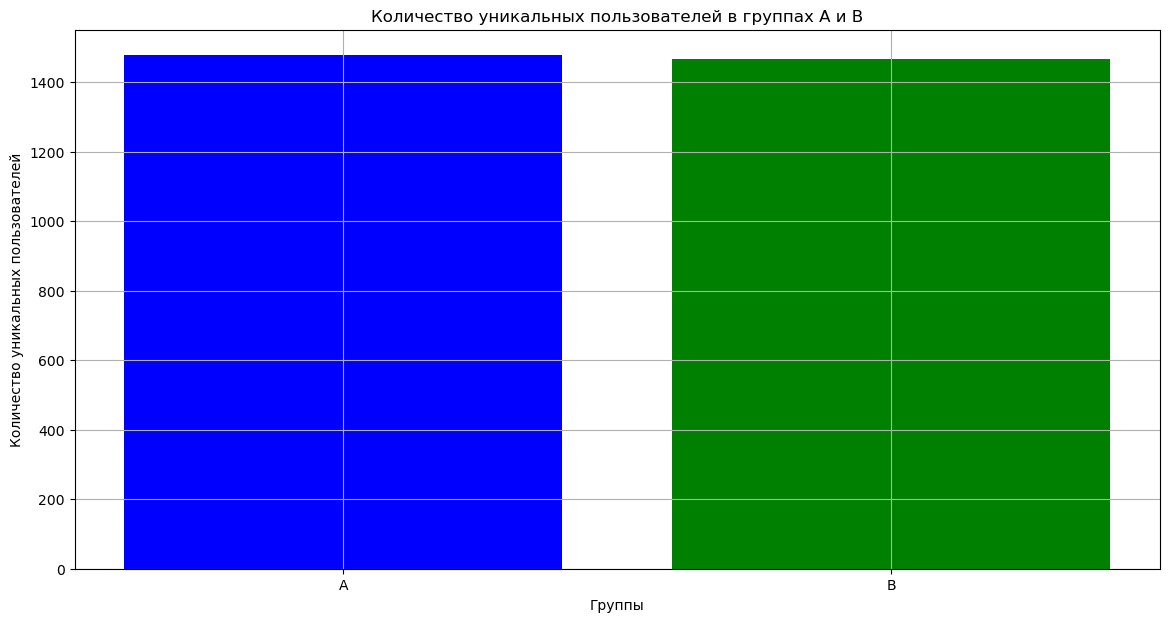

In [26]:
# Считываем данные A/B-теста
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Рассчитываем количество уникальных пользователей в каждой из экспериментальных групп
unique_users = sessions_test_part.groupby('test_group')['user_id'].nunique()

# Рассчитываем процентную разницу
A = unique_users['A']
B = unique_users['B']
percent_difference = 100 * (abs(A - B) / A)

print(f"Процентная разница в количестве пользователей в группах A и B: {percent_difference:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))
plt.bar(unique_users.index, unique_users.values, color=['blue', 'green'])
plt.title('Количество уникальных пользователей в группах A и B')
plt.xlabel('Группы')
plt.ylabel('Количество уникальных пользователей')
plt.grid()
plt.show()

#### Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах убедимся в том, что группы независимы. 

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедимся, что таких нет.

In [28]:
# Проверка пересечений пользователей между группами A и B
users_a = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'])
users_b = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'])

intersection = users_a.intersection(users_b)
print(f"Количество пользователей, которые попали в обе группы: {len(intersection)}")

Количество пользователей, которые попали в обе группы: 0


#### Равномерность разделения пользователей по устройствам
Также убедимся в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

device
Android    0.444144
Mac        0.105619
PC         0.249831
iPhone     0.200406
Name: user_id, dtype: float64

device
Android    0.455662
Mac        0.100955
PC         0.259891
iPhone     0.183492
Name: user_id, dtype: float64

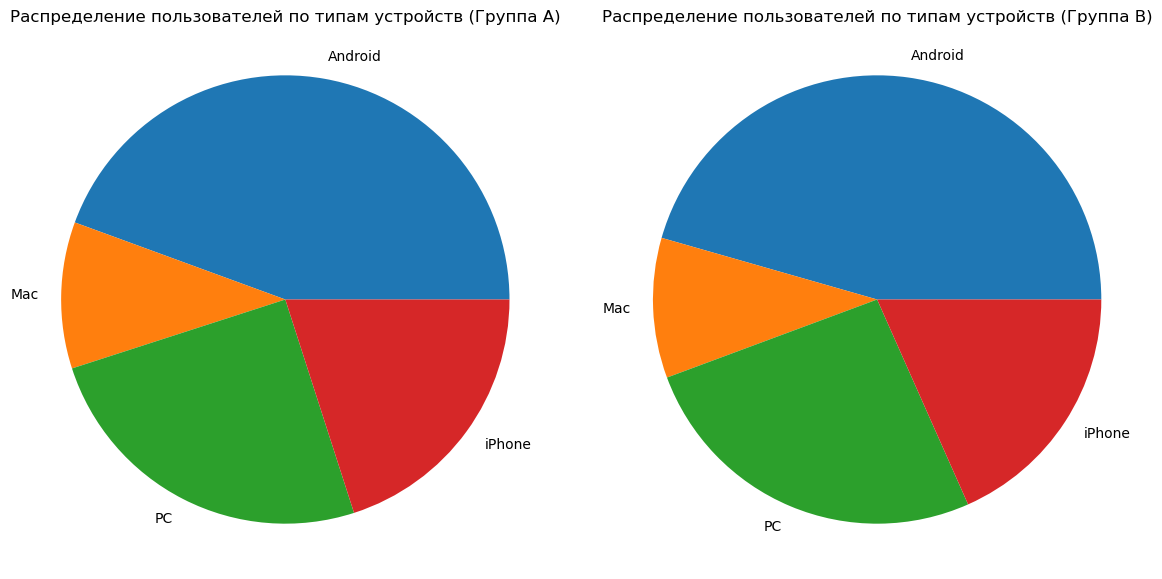

In [30]:
# Рассчитаем долю пользователей по типам устройств для группы A
device_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique() / sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
display(device_a)
# Рассчитаем долю пользователей по типам устройств для группы B
device_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique() / sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()
display(device_b)
# Построение круговой диаграммы для группы A
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  
plt.pie(device_a, labels=device_a.index)
plt.title('Распределение пользователей по типам устройств (Группа A)')
plt.axis('equal') 

# Построение круговой диаграммы для группы B
plt.subplot(1, 2, 2)  
plt.pie(device_b, labels=device_b.index)
plt.title('Распределение пользователей по типам устройств (Группа B)')
plt.axis('equal') 

plt.show()


#### Равномерность распределения пользователей по регионам
Убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

region
CIS     0.436019
EU      0.151659
MENA    0.412322
Name: user_id, dtype: float64

region
CIS     0.439973
EU      0.148022
MENA    0.412005
Name: user_id, dtype: float64

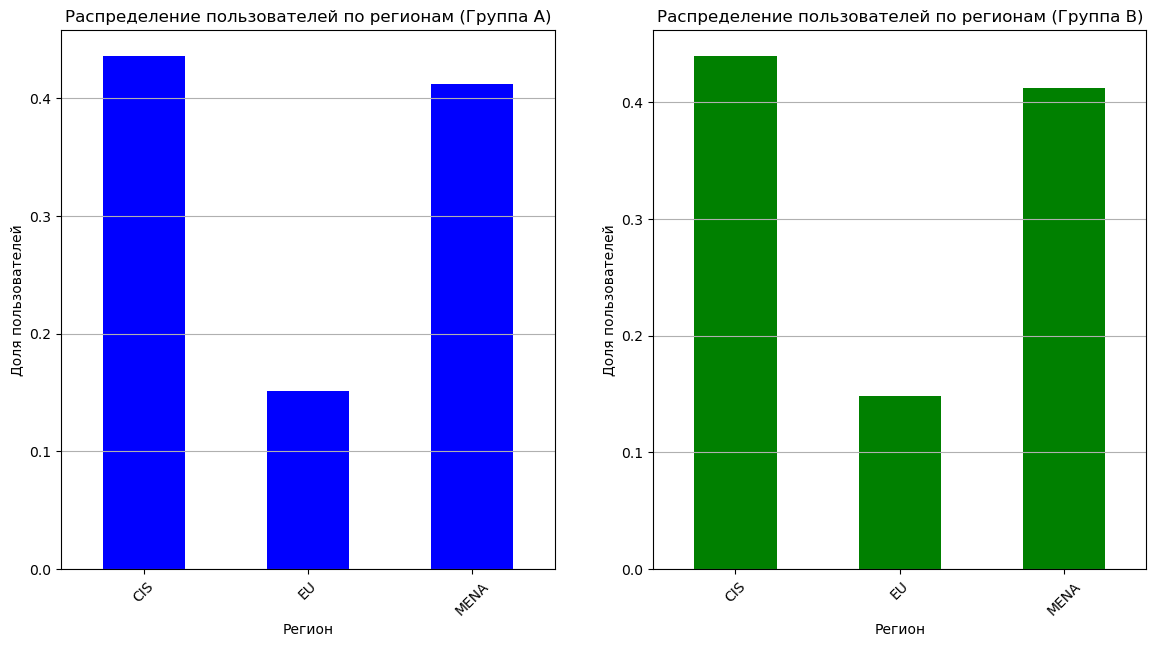

In [32]:
# Рассчитаем долю пользователей по регионам для группы A
region_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique() / sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
display(region_a)
# Рассчитаем долю пользователей по регионам для группы B
region_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique() / sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()
display(region_b)
# Построение столбчатой диаграммы для группы A
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)  
region_a.plot(kind='bar', color='blue')
plt.title('Распределение пользователей по регионам (Группа A)')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Построение столбчатой диаграммы для группы B
plt.subplot(1, 2, 2) 
region_b.plot(kind='bar', color='green')
plt.title('Распределение пользователей по регионам (Группа B)')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


#### Вывод после проверки A/B-теста

При анализе данных за первые три дня A/B-теста было обнаружено, что количество уникальных пользователей в группах A и B отличается. Процентная разница в количестве пользователей между группами составила 0.74 %, что некритично и этим различием можно принебречь. Также не было обнаружено пользователей, которые одновременно находились бы в группах А и В, это говорит нам о том, что выборки независимы, разделение на тестовую и контрольную группы было проведено корректно.
Анализ распределения пользователей по устройствам показал, что группы A и B имеют схожее распределение по типам устройств и регионам, что указывает на равномерность выборок.

### Проверка результатов A/B-теста

#### Получение результатов теста и подсчёт основной метрики

- Сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [37]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Создаём дополнительный столбец good_session
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

#### Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будете сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы.

In [39]:
# Рассчитываем количество уникальных сессий
daily_sessions = (sessions_test.groupby(['session_date', 'test_group']).agg(unique_sessions=('session_id', 'nunique')).reset_index())

# Разделяем данные на группы A и B
group_a = daily_sessions[daily_sessions['test_group'] == 'A']['unique_sessions']
group_b = daily_sessions[daily_sessions['test_group'] == 'B']['unique_sessions']

# Выполняем t-тест для проверки равенства средних двух выборок
stat_ttest, p_value_ttest = stats.ttest_ind(group_a, group_b)

# Выводим p-value
print(f"p-value: {p_value_ttest}")

# Интерпретация p-value
alpha = 0.05
if p_value_ttest > alpha:
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
else:
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')

p-value: 0.938219304859116
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны


#### Сравнение доли успешных сессий
Использем созданный на первом шаге задания столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе. 

In [41]:
# Рассчитываем долю успешных сессий для группы A
success_a = (sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean())

# Рассчитываем долю успешных сессий для группы B
success_b = (sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean())

# Рассчитываем разницу в доле успешных сессий
difference = success_a - success_b

# Выводим результаты
print(f"Доля успешных сессий в группе A: {success_a:.4f}")
print(f"Доля успешных сессий в группе B: {success_b:.4f}")
print(f"Разница в доле успешных сессий (A - B): {difference:.4f}")


Доля успешных сессий в группе A: 0.3077
Доля успешных сессий в группе B: 0.3183
Разница в доле успешных сессий (A - B): -0.0106


#### Насколько статистически значимо изменение ключевой метрики

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведем на экран полученное значение p-value и свои выводы о статистической значимости. 

In [43]:
# Подсчитываем количество успешных и неуспешных сессий для каждой группы
success_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
total_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].count()

success_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
total_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].count()

# Выполняем z-тест
stat_ztest, p_value_ztest = proportions_ztest([success_a, success_b], [total_a, total_b])

# Выводим результаты
print(f"p-value: {p_value_ztest:.4f}")
alpha = 0.05  
if p_value_ztest > alpha:
    print(f'p-value={p_value_ztest:.4f} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'p-value={p_value_ztest:.4f} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')


p-value: 0.0003
p-value=0.0003 < 0.05
Нулевая гипотеза не находит подтверждения!


#### Вывод по результатам A/B-эксперимента

Для проведения А/В теста были задействованы пользователи из двух групп: контрольной (группа А) и тестовой (группа В).

- Необходимый размер выборки для каждой группы составил 17441 пользователя.
- Длительность проведения теста составила 12 дней.
- В ходе анализа результатов теста было обнаружено, что внедрение нового алгоритма привело к увеличению доли успешных сессий (успешной считается сессия, в которой было просмотрено 4 и более страниц).
- В тестовой группе В доля успешных сессий оказалась выше на 1.1%, чем в контрольной группе А. Это говорит о том, что новый алгоритм положительно повлиял на вовлеченность пользователя.
- При проведении z-теста было выявлено, что p-value меньше уровня значимости alpha (0.05), исходя из этого можно сделать вывод, что данное изменение является статистически значимым.
  
Учитывая положительный эффект внедрения нового алгоритма, можно рекомендовать внедрять данное нововведение в приложение.
